In [1]:
import sys
sys.path.append("/u/dssc/zenocosini/helm_suite/MCQA_Benchmark")
from metrics.utils_copy import *
from metrics.query import DataFrameQuery
from common.utils import *

#from sklearn.feature_selection import mutual_info_regression MISSIN?
from dadapy.data import Data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.decomposition import KernelPCA
from sklearn.metrics import pairwise_distances
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

from pathlib import Path
from collections import Counter
!export OMP_NUM_THREADS=1

In [2]:
_PATH = Path("/orfeo/scratch/dssc/zenocosini/mmlu_result/")
_PATH_RESULT = Path("/orfeo/cephfs/home/dssc/zenocosini/helm_suite/MCQA_Benchmark/metrics/cluster_cartoon")

In [17]:
_PATH = Path("/orfeo/scratch/dssc/zenocosini/mmlu_result/")
_PATH_RESULT = Path("/orfeo/cephfs/home/dssc/zenocosini/helm_suite/MCQA_Benchmark/metrics/cluster_cartoon")

class Pipeline():
    def __init__(self):
        self.df = None
    
    def preprocess(self, query):
        hidden_states, logits, hidden_states_stat = self.retrieve(query)
        
        filtered_hidden_states, filtered_logits, filter_hidden_states_stat, repeated_indices = filter_indentical_rows(hidden_states, logits, hidden_states_stat)
        return filtered_hidden_states, \
               filtered_logits, \
               filter_hidden_states_stat, \
               repeated_indices
        

            
    def compute(self):
        z = 1
        models = ["meta-llama/Llama-2-7b-hf",
                  "meta-llama/Llama-2-7b-chat-hf",
                  "meta-llama/Llama-2-13b-chat-hf",
                  "meta-llama/Llama-2-70b-hf",
                  "meta-llama/Llama-2-70b-chat-hf",
                  "meta-llama/Llama-3-8b-hf",
                  "meta-llama/Llama-3-70b-hf",]
        models = ["meta-llama/Llama-3-8b-chat-hf",
                  "meta-llama/Llama-3-70b-chat-hf",]
        rows = []
        for model in models:
            for shot in [0,2,5]:
                # if "chat" in model and shot == 5:
                #     continue
                if "70" in model and shot == 5 and "chat" not in model:
                    shot = 4
                elif "70" in model and "chat" in model and shot == 5:
                    continue
                dict_query = {"method":"last",
                              "model_name": model,
                              "train_instances": shot}
                hidden_states, logits, hidden_states_stat, repeated_indices = self.preprocess(dict_query)
                for layer in [7,20,3]:
                    print(f'Iteration with model:{model}, shot:{shot}, layer:{layer}')
                    # compute clustering
                    print(hidden_states.shape)
                    if layer == 33:
                        data = Data(logits)
                    else:
                        data = Data(hidden_states[:,layer,:])
                    data.compute_distances(maxk=1000)
                    clusters_assignement = data.compute_clustering_ADP(Z=z)
                    
                    # filter small cluster
                    cluster_to_remove = np.where(np.bincount(clusters_assignement)<20)
                    bad_indices = np.where(np.isin(clusters_assignement, cluster_to_remove[0]))[0]
                    clusters_assignement = np.delete(clusters_assignement, bad_indices)
                    filtered_hidden_states_stat = hidden_states_stat.drop(bad_indices)
                    
                    
                    # compute centroids
                    distance_matrix = self.compute_centroids(data, cluster_to_remove)
                    
                    # compute attributes
                    cluster_counts, most_represented = self.attributes_df(clusters_assignement, 
                                                                          filtered_hidden_states_stat)
                    
                    row = [model, shot, layer, most_represented, distance_matrix, cluster_counts]
                    rows.append(row)
                checkpoint_path = Path(_PATH_RESULT / f"checkpoint.pkl")
                
                with open(checkpoint_path, "wb") as f:
                    pickle.dump(rows, f)
            
        df = pd.DataFrame(rows, columns = ["model", 
                                           "shot", 
                                           "layer", 
                                           "most_represented", 
                                           "distance_matrix", 
                                           "cluster_counts"])
        self.df = df
        self.df.to_pickle(_PATH_RESULT / "df_3_8.chat_pkl")
                    
    def plot(self):
        for index, row in self.df.iterrows():
            model = row["model"]
            shot = row["shot"]
            layer = row["layer"]
            most_represented = row["most_represented"]
            distance_matrix = row["distance_matrix"]
            cluster_counts = row["cluster_counts"]    
            clusters, counts = zip(*sorted(cluster_counts.items()))
            mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
            positions = mds.fit_transform(distance_matrix)
            fig, ax = plt.subplots()
            norm = Normalize(vmin=0, vmax=1)
            cmap = plt.cm.coolwarm  
            scalar_map = ScalarMappable(norm=norm, cmap=cmap)
            cluster_colors = scalar_map.to_rgba(most_represented["percentage"])
            for pos, count, cluster, color in zip(positions, counts, clusters,cluster_colors ):
                ax.scatter(pos[0], pos[1], s= count, color=color, label=color, edgecolors='black', linewidth=1)
            ax.set_title('Cluster Visualization')
            ax.set_xlabel('Dimension 1')
            ax.set_ylabel('Dimension 2')
            plt.colorbar(scalar_map, ax=ax, label='Percentage of STEM subjects')
            plt.title(f"Model: {model}, Shot: {shot}, Layer: {layer}") 
            plt.show()
            print(model.split("/")[1])
            plt.savefig(_PATH_RESULT / f"model_{model.split('/')[1]}_shot_{shot}_layer_{layer}.png")
        
    def retrieve(self, query):
        tsm = TensorStorageManager()
        query = DataFrameQuery(query)
        hidden_states,logits, hidden_states_stat = tsm.retrieve_tensor(query, "npy")
        return hidden_states,logits, hidden_states_stat
        
    def attributes_df(self,  
                      clusters_assignement, 
                      hidden_states_stat):
        subjects = hidden_states_stat["dataset"]
        map_sub_ind = {class_name: n for n,class_name in enumerate(set(subjects))}
        map_ind_sub = {n: class_name for n,class_name in enumerate(set(subjects))}
        
        label_per_row = np.array([map_sub_ind[e] for e in subjects])
        cluster_sub = np.concatenate([np.expand_dims(label_per_row,axis =0),np.expand_dims(clusters_assignement,axis =0)], axis = 0)
        cluster_sub = cluster_sub.T
        
        stem,not_stem = self.stem(hidden_states_stat)
        sub_binary = list(map(lambda r: r in stem,list(map(lambda r: map_ind_sub[r],cluster_sub[:,0]))))
        
        df = pd.DataFrame({"type": sub_binary, "cluster": cluster_sub[:,1]})
        
        df["type"] = df["type"].astype(int)
        most_represented = df.groupby('cluster')['type'].agg(lambda x: x.mean()).reset_index()
        most_represented.rename(columns={"type":"percentage"}, inplace=True)
        
        cluster_counts = Counter(cluster_sub[:, 1])
        
        return cluster_counts, most_represented
    
    def stem(self, 
             hidden_states_stat):
        subjects = hidden_states_stat["dataset"]
        subjects_list = np.unique(subjects)
        stem_subjects = ['abstract_algebra', 'anatomy', 'astronomy', 'college_biology', 'college_chemistry',
                 'college_computer_science', 'college_mathematics', 'college_medicine', 'college_physics',
                 'computer_security', 'conceptual_physics', 'electrical_engineering', 'high_school_biology',
                 'high_school_chemistry', 'high_school_computer_science', 'high_school_mathematics',
                 'high_school_physics', 'high_school_statistics', 'machine_learning', 'medical_genetics',
                 'professional_medicine', 'virology', 'elementary_mathematics']

        # Determine STEM and non-STEM
        is_stem = np.isin(subjects_list, stem_subjects)
        stem = subjects_list[is_stem]
        not_stem = subjects_list[~is_stem]
        
        return stem, not_stem
    
    def compute_centroids(self, data, cluster_to_remove):
        # compute centroids
        indices_per_cluster = data.cluster_indices
        centroids = list(map(lambda r: np.mean(data.X[r],axis=0), indices_per_cluster))
        centroids = list(map(lambda r: np.mean(data.X[r],axis=0), indices_per_cluster))
        centroids = np.stack(centroids)
        centroids = np.delete(centroids,cluster_to_remove, axis=0)

        distance_matrix = pairwise_distances(centroids, metric='l2')
        
        return distance_matrix
            
    def run(self):
        self.compute()
        self.plot()
        
    
def find_identical_rows(matrix):
    
    # View the rows as a structured array to handle them as tuples
    dtype = [('row', matrix.dtype, matrix.shape[1])]
    structured_array = matrix.view(dtype)
    
    # Find unique rows and their indices
    _, inverse_indices = np.unique(structured_array, return_inverse=True)
    
    # Find where each row appears for the first time and their counts
    unique_rows, counts = np.unique(inverse_indices, return_counts=True)
    
    # Filter out unique rows, keeping only duplicates
    repeated_indices = [np.where(inverse_indices == i)[0] for i in unique_rows[counts > 1]]
    return repeated_indices

def filter_indentical_rows(hidden_states,logits, hidden_states_stat):
    # we pick only 7 because the repeated indices are supposed to be equal at each layer
    repeated_indices = find_identical_rows(hidden_states[:,7,:])
    indices_to_exclude = [index[0] for index in repeated_indices]
    filtered_hidden_states = np.delete(hidden_states, indices_to_exclude, axis=0)
    filtered_logits = np.delete(logits, indices_to_exclude, axis=0)
    filtered_hidden_states_stat = hidden_states_stat.drop(indices_to_exclude)
    filtered_hidden_states_stat.reset_index(inplace=True)
    print(filtered_hidden_states.shape)
    return filtered_hidden_states, filtered_logits, filtered_hidden_states_stat, repeated_indices

(14012, 33, 4096)
Iteration with model:meta-llama/Llama-3-8b-chat-hf, shot:0, layer:7
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-8b-chat-hf, shot:0, layer:20
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-8b-chat-hf, shot:0, layer:3
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


(14012, 33, 4096)
Iteration with model:meta-llama/Llama-3-8b-chat-hf, shot:2, layer:7
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-8b-chat-hf, shot:2, layer:20
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-8b-chat-hf, shot:2, layer:3
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


(14012, 33, 4096)
Iteration with model:meta-llama/Llama-3-8b-chat-hf, shot:5, layer:7
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-8b-chat-hf, shot:5, layer:20
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-8b-chat-hf, shot:5, layer:3
(14012, 33, 4096)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


(14012, 81, 8192)
Iteration with model:meta-llama/Llama-3-70b-chat-hf, shot:0, layer:7
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-70b-chat-hf, shot:0, layer:20
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-70b-chat-hf, shot:0, layer:3
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


(14012, 81, 8192)
Iteration with model:meta-llama/Llama-3-70b-chat-hf, shot:2, layer:7
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-70b-chat-hf, shot:2, layer:20
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


Iteration with model:meta-llama/Llama-3-70b-chat-hf, shot:2, layer:3
(14012, 81, 8192)


/orfeo/cephfs/home/dssc/zenocosini/helm_suite/DADApy/dadapy/kstar.py:101: UserWarning: Careful! The intrinsic dimension is not defined. Computing it unsupervisedly with 'compute_id_2NN()' method
  warnings.warn(


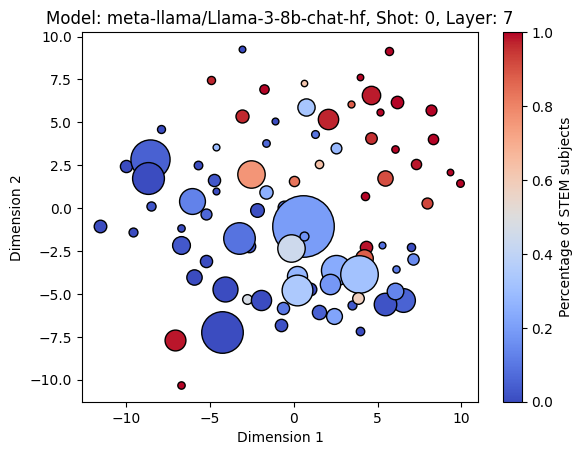

Llama-3-8b-chat-hf


<Figure size 640x480 with 0 Axes>

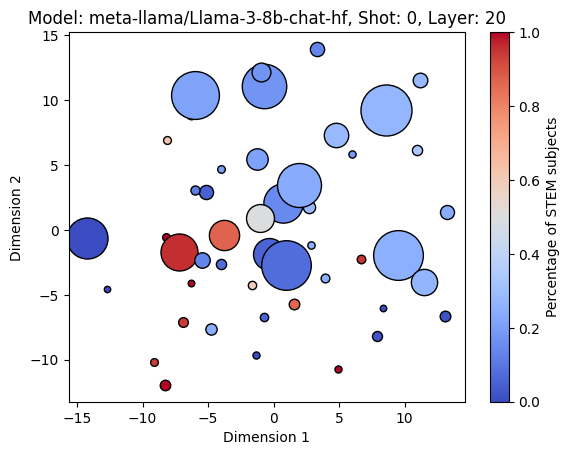

Llama-3-8b-chat-hf


<Figure size 640x480 with 0 Axes>

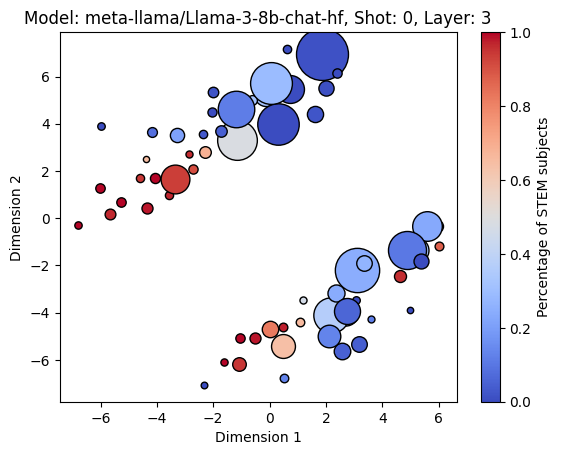

Llama-3-8b-chat-hf


<Figure size 640x480 with 0 Axes>

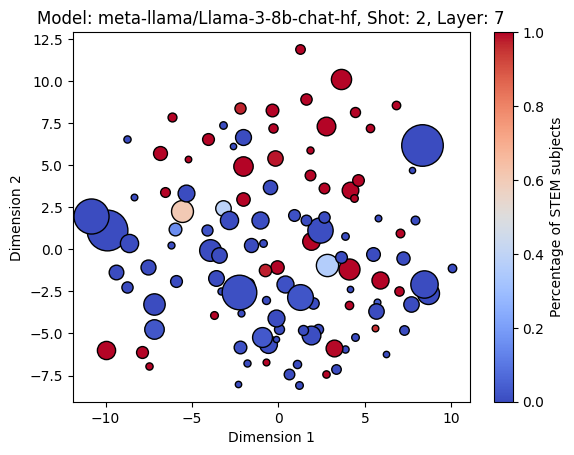

Llama-3-8b-chat-hf


<Figure size 640x480 with 0 Axes>

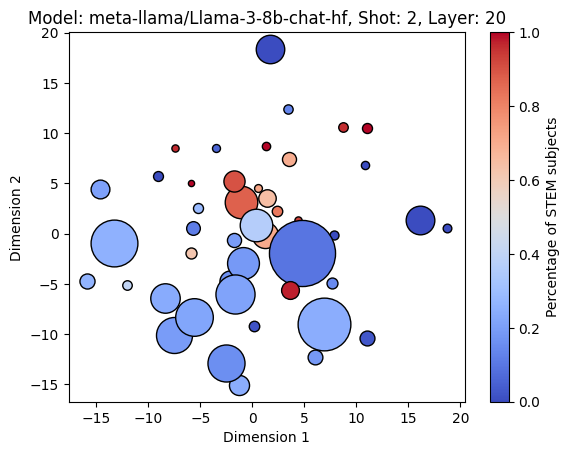

Llama-3-8b-chat-hf


<Figure size 640x480 with 0 Axes>

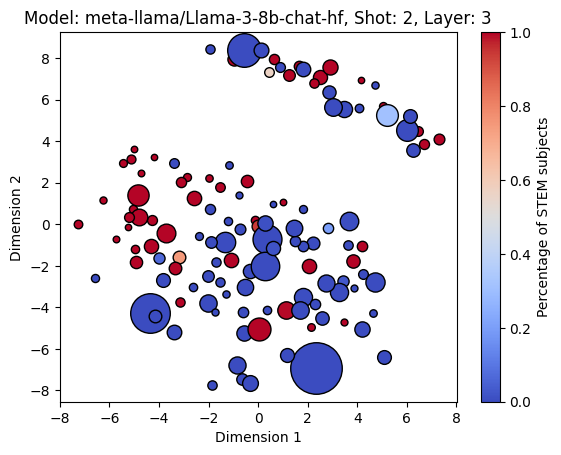

Llama-3-8b-chat-hf


<Figure size 640x480 with 0 Axes>

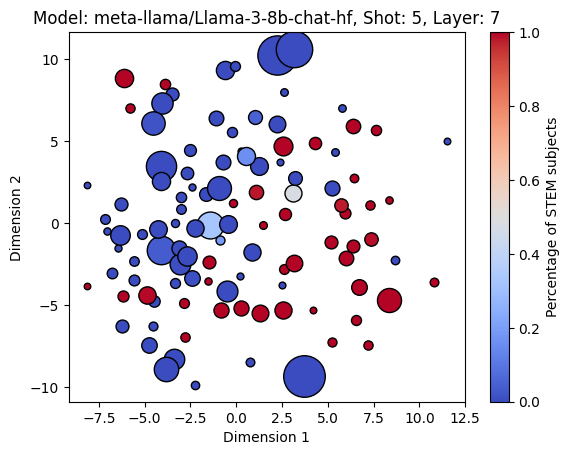

Llama-3-8b-chat-hf


<Figure size 640x480 with 0 Axes>

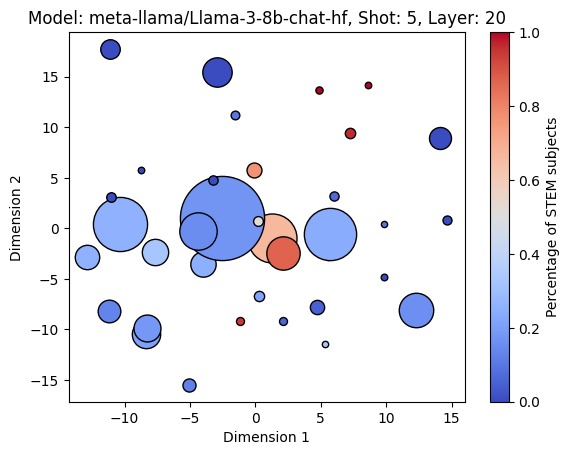

Llama-3-8b-chat-hf


<Figure size 640x480 with 0 Axes>

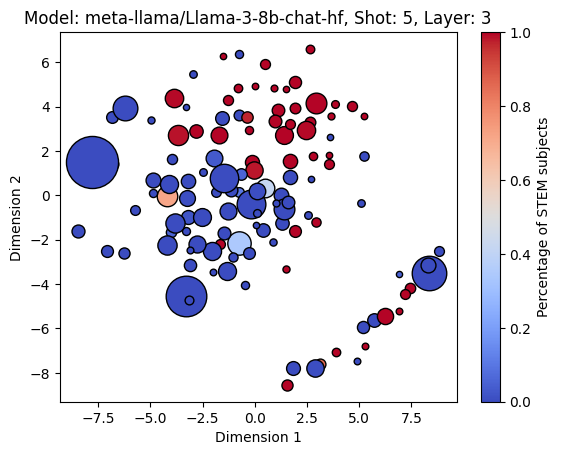

Llama-3-8b-chat-hf


<Figure size 640x480 with 0 Axes>

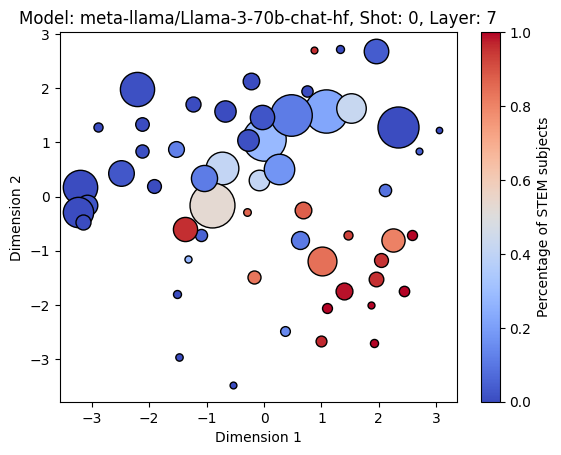

Llama-3-70b-chat-hf


<Figure size 640x480 with 0 Axes>

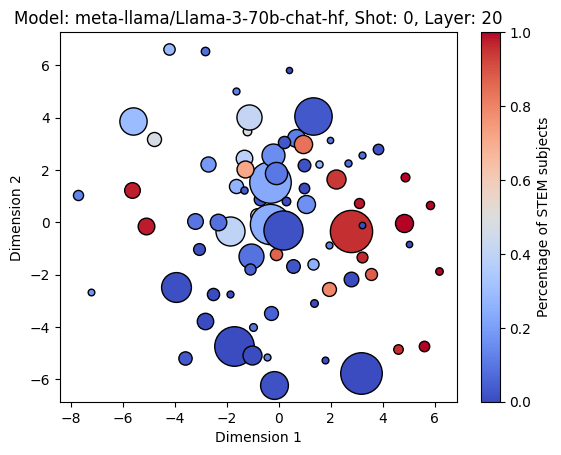

Llama-3-70b-chat-hf


<Figure size 640x480 with 0 Axes>

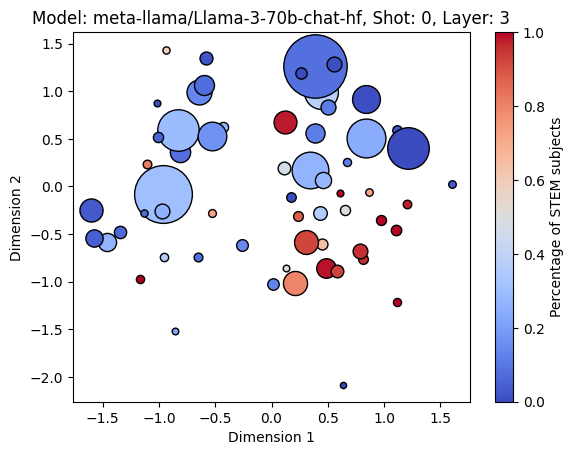

Llama-3-70b-chat-hf


<Figure size 640x480 with 0 Axes>

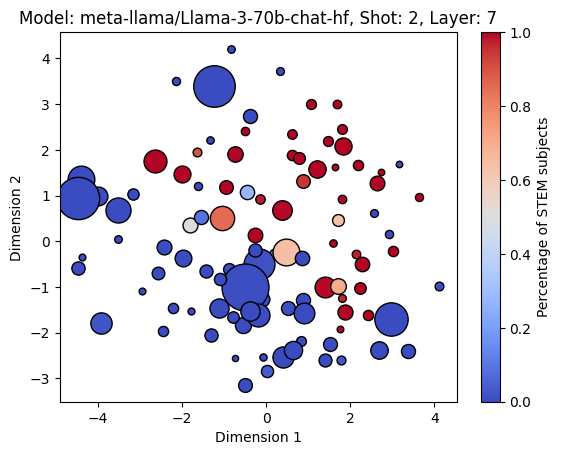

Llama-3-70b-chat-hf


<Figure size 640x480 with 0 Axes>

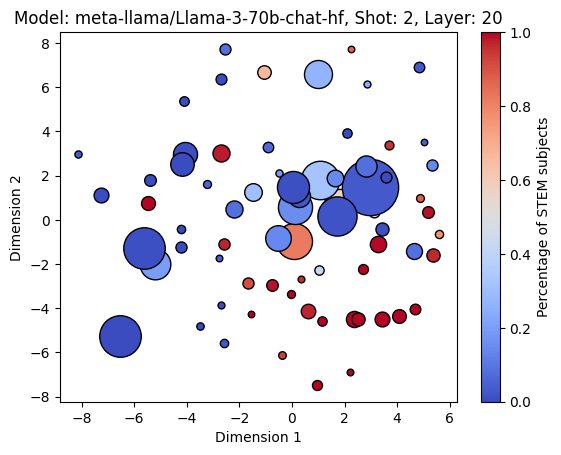

Llama-3-70b-chat-hf


<Figure size 640x480 with 0 Axes>

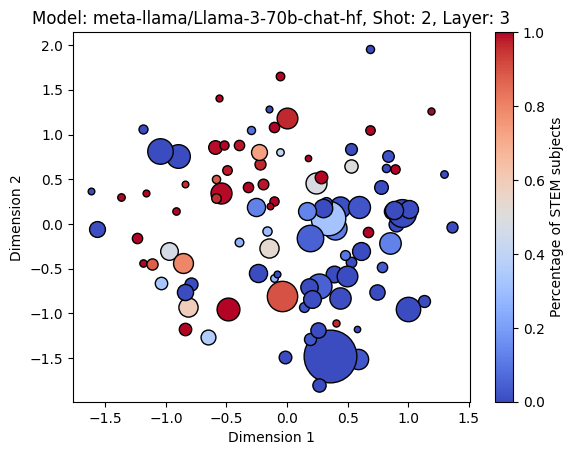

Llama-3-70b-chat-hf


<Figure size 640x480 with 0 Axes>

In [18]:
pipeline = Pipeline()
pipeline.run()

In [3]:
dict_query = {"method":"last",
              "model_name":  "meta-llama/Llama-3-8b-ft-hf",
              "train_instances": 0}                               
tsm = TensorStorageManager()
query = DataFrameQuery(dict_query)
hidden_states,logits, hidden_states_stat = tsm.retrieve_tensor(query, "npy")

# TEST PLOT

In [ ]:
for model in df["model"].unique():
    for shot in df["shot"].unique():
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
        for n,layer in enumerate(df["layer"].unique()):
            n=n-1
            df_iter = df.query(f"model=='{model}' and shot=={shot} and layer=={layer}")
            row = df_iter.to_dict()
            model = list(row["model"].items())[0][1]
            shot = list(row["shot"].items())[0][1]
            layer = list(row["layer"].items())[0][1]
            most_represented = list(row["most_represented"].items())[0][1]
            distance_matrix = list(row["distance_matrix"].items())[0][1]
            cluster_counts = list(row["cluster_counts"].items())[0][1]
            clusters, counts = zip(*sorted(cluster_counts.items()))
            mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
            positions = mds.fit_transform(distance_matrix)
            fig, ax = plt.subplots()
            norm = Normalize(vmin=0, vmax=1)
            cmap = plt.cm.coolwarm  
            scalar_map = ScalarMappable(norm=norm, cmap=cmap)
            cluster_colors = scalar_map.to_rgba(most_represented["percentage"])
            for pos, count, cluster, color in zip(positions, counts, clusters,cluster_colors ):
                print(pos)
                axs[n].scatter(pos[0], pos[1], s= count, color=color, label=color, edgecolors='black', linewidth=1)
            axs[n].set_title(f"{model.split('/')[1]},shot:{shot},layer:{layer}")
            axs[n].set_xlabel('Dimension 1')
            axs[n].set_ylabel('Dimension 2')
            plt.tight_layout()
        plt.colorbar(scalar_map, ax=ax, label='Percentage of STEM subjects')
        plt.show()
        plt.savefig(_PATH_RESULT / f"{model.split('/')[1]}_shot_{shot}.png")

In [ ]:
for model in df["model"].unique():
    for shot in df["shot"].unique():
        if '70' not in model and shot == 4:
            continue
        elif 'chat' in model and shot != 0:
            continue
        fig, axs = plt.subplots(1, 4, figsize=(15, 5))  # 1 row, 3 columns
        
        for n, layer in enumerate(df["layer"].unique()):
            df_iter = df.query(f"model=='{model}' and shot=={shot} and layer=={layer}")
            
            if df_iter.empty:
                continue  # Skip if no data is returned for this query
            
            row = df_iter.to_dict('list')
            most_represented = row["most_represented"][0]
            distance_matrix = row["distance_matrix"][0]
            cluster_counts = row["cluster_counts"][0]
            clusters, counts = zip(*sorted(cluster_counts.items()))
            
            mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
            positions = mds.fit_transform(distance_matrix)
            
            norm = Normalize(vmin=0, vmax=1)
            cmap = plt.cm.coolwarm  
            scalar_map = ScalarMappable(norm=norm, cmap=cmap)
            cluster_colors = scalar_map.to_rgba(most_represented["percentage"])
            
            for pos, count, cluster, color in zip(positions, counts, clusters, cluster_colors):
                
                axs[n].scatter(pos[0], pos[1], s=count, color=color, label=cluster, edgecolors='black', linewidth=1)
            
            axs[n].set_title(f"{model.split('/')[-1]}, Shot: {shot}, Layer: {layer}")
            axs[n].set_xlabel('Dimension 1')
            axs[n].set_ylabel('Dimension 2')

        plt.tight_layout()
        plt.colorbar(scalar_map, ax=axs, label='Percentage of STEM subjects')  # Attaching colorbar to all subplots
        plt.show()
        fig.savefig(_PATH_RESULT / f"{model.split('/')[-1]}_shot_{shot}.png")  # Save the figure after plotting


In [ ]:
for model in df_all["model"].unique():
    for shot in df_all["shot"].unique():
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns
        for n,layer in enumerate(df_all["layer"].unique()):
            n=n-1
            df_iter = df_all.query(f"model=='{model}' and shot=={shot} and layer=={layer}")
            row = df_iter.to_dict()
            model = list(row["model"].items())[0][1]
            shot = list(row["shot"].items())[0][1]
            layer = list(row["layer"].items())[0][1]
            most_represented = list(row["most_represented"].items())[0][1]
            distance_matrix = list(row["distance_matrix"].items())[0][1]
            cluster_counts = list(row["cluster_counts"].items())[0][1]
            clusters, counts = zip(*sorted(cluster_counts.items()))
            mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
            positions = mds.fit_transform(distance_matrix)
            fig, ax = plt.subplots()
            norm = Normalize(vmin=0, vmax=1)
            cmap = plt.cm.coolwarm  
            scalar_map = ScalarMappable(norm=norm, cmap=cmap)
            cluster_colors = scalar_map.to_rgba(most_represented["percentage"])
            for pos, count, cluster, color in zip(positions, counts, clusters,cluster_colors ):
                
                axs[n].scatter(pos[0], pos[1], s= count, color=color, label=color, edgecolors='black', linewidth=1)
            axs[n].set_title(f"{model.split('/')[1]},shot:{shot},layer:{layer}")
            axs[n].set_xlabel('Dimension 1')
            axs[n].set_ylabel('Dimension 2')
            plt.tight_layout()
        plt.colorbar(scalar_map, ax=ax, label='Percentage of STEM subjects')
        plt.show()
        plt.savefig(_PATH_RESULT / f"{model.split('/')[1]}_shot_{shot}.png")

# Plot 2.A

In [3]:
# df_sub_overlap = pd.read_pickle(_PATH/"subject_overlap_None.pkl")
df_sub_overlap = pd.read_pickle(_PATH/"transposed_dataset/result/subject_overlap_all.pkl")
df_sub_overlap.rename(columns={"shot":"train_instances"}, inplace = True)

In [12]:
!ls  /orfeo/scratch/dssc/zenocosini/mmlu_result/transposed_dataset/result

id.pkl				       Llama-3-8b-chat-hf_intrinsic_dim.pkl
intrinsic_dim.pkl		       Llama-3-8b-hf_intrinsic_dim.pkl
label_clustering_dataset.pkl	       Llama-3-8b-hf_letter_overlap.pkl
Llama-3-70b-chat-hf_intrinsic_dim.pkl  subject_overlap_all.pkl
Llama-3-70b-hf_intrinsic_dim.pkl


In [9]:
df_all =  pd.read_pickle(_PATH_RESULT / "df_all.pkl")


In [14]:
data_1 = df_all.query("model == 'meta-llama/Llama-3-8b-hf' \
                               and shot==5 \
                               and layer==7")
data_2 = df_all.query("model == 'meta-llama/Llama-3-8b-ft-hf' \
                               and shot==0 \
                               and layer==7")


In [6]:
df_all = pd.concat([df_sub_overlap,df_all])

In [37]:
overlaps_label1.shape

(33,)

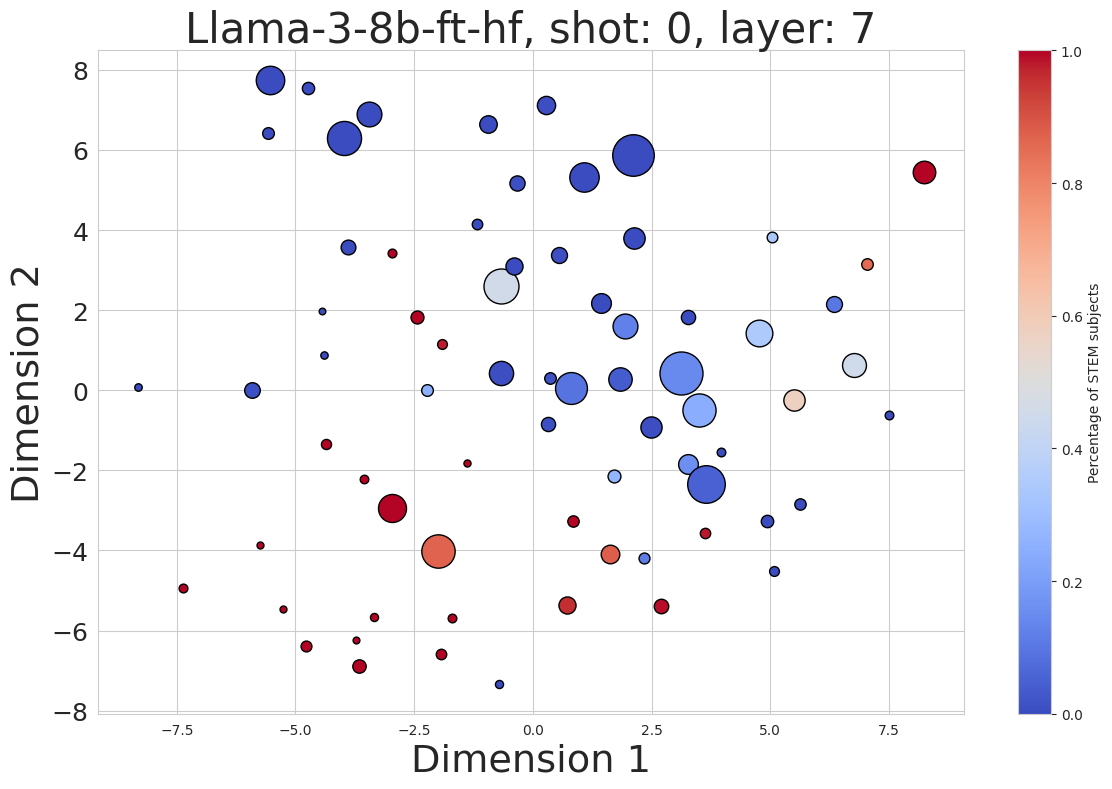

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mpl 
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from dataclasses import dataclass

@dataclass
class ConfigPlotSize:
    width: int  = 12
    height: int = 8
    xticks: int = 18
    yticks: int = 18
    xlabel: int = 27.5
    ylabel: int = 27.5
    title: int  = 30
    hspace: int = 0.8
    wspace: int = 0.8
    legend: int = 23
    linewidth: int = 2.5
    s: int = 100

conf_size = ConfigPlotSize()
# Setting the plot style globally
sns.set_style("whitegrid")

# Setup figure and axes for 3 plots in one row
plt.figure(figsize=(conf_size.width, conf_size.height))

# Data preparation and extraction
data = df_sub_overlap# Assuming df_sub_overlap is defined elsewhere
models = ['meta-llama-Llama-3-8b-hf', 'meta-llama-Llama-3-8b-ft-hf']
k = 0.1
algorithm = "overlap"

def extract_data(model, shot, method='last', class_fraction=k):
    query = f"model=='{model}' and train_instances=={shot} and method=='{method}' and class_fraction=={class_fraction}"
    result = data.query(query)[algorithm].iloc[0]
    return np.stack(result)

# Extract data for plotting
overlaps_label1 = extract_data(models[0], '0')
overlaps_label2 = extract_data(models[0], shot='5' if "70" in models[0] else '5')
overlaps_label3 = extract_data(models[1], '0')

# Calculate layer positions for plotting
layers = np.arange(0, overlaps_label1.shape[0])

# First subplot: Overlap visualizations using line and scatter plots
# for i, (overlaps, label, marker) in enumerate(zip([overlaps_label1, overlaps_label2, overlaps_label3],
#                                                      ["0 shot pt", "5 shot pt", "0 shot chat"],
#                                                      ['o', 'o', 'X'])):
#     sns.scatterplot(x=layers, y=overlaps, s = conf_size.s, marker=marker)
#     sns.lineplot(x=layers, y=overlaps, label=label, linewidth = conf_size.linewidth)
# tick_positions = np.arange(1, overlaps_label1.shape[0], 4)  # Generates positions 0, 4, 8, ...
# tick_labels = layers[tick_positions]  # Get the corresponding labels from x
# plt.xticks(ticks=tick_positions, labels=tick_labels, fontsize = conf_size.xticks)
# plt.tick_params(axis='y', labelsize=conf_size.yticks)
# plt.xlabel("layer", fontsize=conf_size.xlabel)
# plt.ylabel("label overlap", fontsize = conf_size.ylabel)
# plt.title(f"Subject overlap Llama 3 8b", fontsize=conf_size.title)
# plt.legend(fontsize = conf_size.legend)
# Assuming `data_1` and `data_2` are predefined for the next plots
for n, data_n in enumerate([data_2], start=1):
    row = data_n.to_dict()
    model = list(row["model"].items())[0][1]
    shot = list(row["shot"].items())[0][1]
    layer = list(row["layer"].items())[0][1]
    most_represented = list(row["most_represented"].items())[0][1]
    distance_matrix = list(row["distance_matrix"].items())[0][1]
    cluster_counts = list(row["cluster_counts"].items())[0][1]
    
    # MDS and clustering visualization
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    positions = mds.fit_transform(distance_matrix)
    clusters, counts = zip(*sorted(cluster_counts.items()))
    
    norm = Normalize(vmin=0, vmax=1)
    cmap = plt.cm.coolwarm
    scalar_map = ScalarMappable(norm=norm, cmap=cmap)
    scalar_map.set_array([]) 
    norm = mpl.colors.Normalize(vmin=0, vmax=2) 
  

    cluster_colors = scalar_map.to_rgba(most_represented["percentage"])
    
    for pos, count, cluster, color in zip(positions, counts, clusters, cluster_colors):
        plt.scatter(pos[0], pos[1], s=count, color=color, label=f'Cluster {cluster}', edgecolors='black', linewidth=1)
    
    plt.title(f"{model.split('/')[1]}, shot: {shot}, layer: {layer}", fontsize=conf_size.title)
    plt.xlabel('Dimension 1', fontsize=conf_size.xlabel)
    plt.ylabel('Dimension 2', fontsize=conf_size.ylabel)
    plt.tick_params(axis='y', labelsize=conf_size.yticks)
    plt.tick_params(axis='y', labelsize=conf_size.yticks)
    
    plt.tight_layout()
    plt.colorbar(scalar_map, label='Percentage of STEM subjects')
    plt.savefig(_PATH_RESULT / f"cartoon_8b_ft.png")
    plt.show()


In [16]:
!pwd

/orfeo/cephfs/home/dssc/zenocosini/helm_suite/MCQA_Benchmark/metrics/cluster_cartoon
